In [77]:
from fenics import *
import matplotlib.pyplot as plt

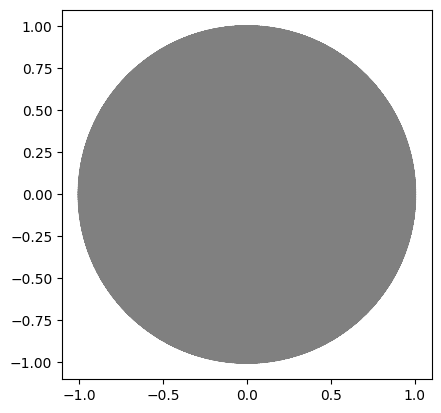

In [78]:
filename = "mesh/meshCircle"
mesh = Mesh(filename + ".xml")
bounds = MeshFunction("size_t", mesh, filename + "_facet_region.xml")
face = MeshFunction("size_t", mesh, filename + "_physical_region.xml")
plot(mesh)

Solving linear variational problem.


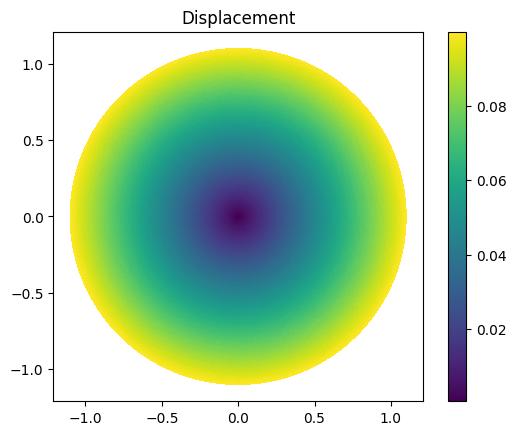

In [79]:
# Scaled variables
E = 21e6
nu = 0.3
mu = E / (2 * (1 + nu))
lambda_ = E * nu / ((1 + nu) * (1 - 2 * nu))

# Create mesh and define function space
V = VectorFunctionSpace(mesh, 'P', 1)

# Define boundary condition
tol = 1E-14

def clamped_boundary(x, on_boundary):
    return on_boundary and x[0] < tol
g = Expression(("0.1*x[0]/sqrt(x[0]*x[0]+x[1]*x[1])", "0.1*x[1]/sqrt(x[0]*x[0]+x[1]*x[1])"), degree=2)
bc = DirichletBC(V, g, bounds,1)


# Define strain and stress

def epsilon(u):
    return 0.5*(grad(u) + grad(u).T)
    #return sym(nabla_grad(u))

def sigma(u):
    return lambda_*div(u)*Identity(d) + 2*mu*epsilon(u)

# Define variational problem
u = TrialFunction(V)
d = u.geometric_dimension()  # space dimension
v = TestFunction(V)
f = Constant((0, 0))  # body force
T = Constant((0, 0))
a = inner(sigma(u), epsilon(v))*dx
L = dot(f, v)*dx + dot(T, v)*ds

# Compute solution
u = Function(V)
solve(a == L, u, bc)

# Plot solution
sol = plot(u, title='Displacement', mode='displacement')
plt.colorbar(sol)

# # Plot stress
# s = sigma(u) - (1./3)*tr(sigma(u))*Identity(d)  # deviatoric stress
# von_Mises = sqrt(3./2*inner(s, s))
# V = FunctionSpace(mesh, 'P', 1)
# von_Mises = project(von_Mises, V)
# plot(von_Mises, title='Stress intensity')

# Compute magnitude of displacement
# u_magnitude = sqrt(dot(u, u))
# u_magnitude = project(u_magnitude, V)
# plot(u_magnitude, 'Displacement magnitude')
# print('min/max u:',
#       u_magnitude.vector().min(),
#       u_magnitude.vector().max())

In [80]:
class CoordinateExpression(UserExpression):
    def eval(self, values, x):
        values[0] = x[0]
        values[1] = x[1]

    def value_shape(self):
        return (2,)
    

coordinate_expression = CoordinateExpression(degree=2)

# Interpolate the coordinate expression into the function space
coordinate_expression_interpolated = interpolate(coordinate_expression, V)

# Define the identity matrix
I = Identity(2)

# Multiply the identity matrix by the coordinate expression
matrix = I * coordinate_expression_interpolated


In [81]:
def randomMatrix(x):
    # Create an identity matrix
    I = Identity(2)

    # Create a diagonal matrix with sin(x[0])*sin(x[1]) on the diagonal
    D = as_matrix([[x[0], 0], [0, x[1]]])

    # Return the sum of the identity matrix and the diagonal matrix
    return I + D
    
f = Expression(("sin(x[0])*sin(x[1])", "cos(x[0])*cos(x[1])"), degree=2)
M = randomMatrix(f)


Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.


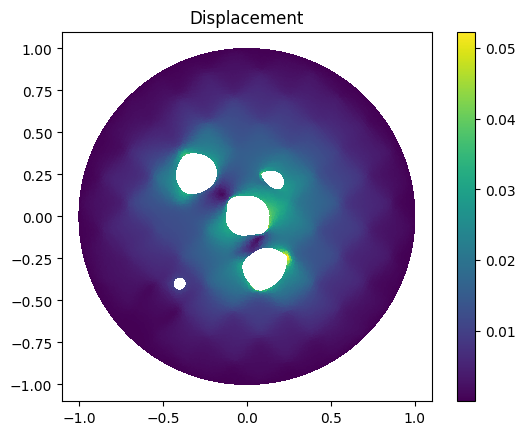

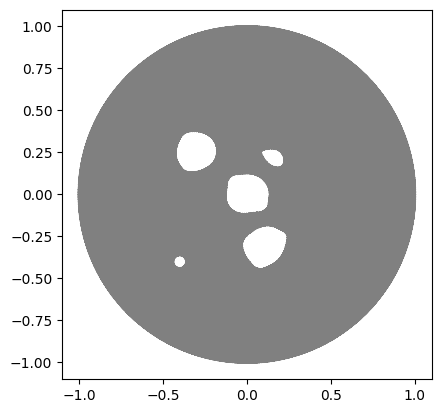

Solving linear variational problem.


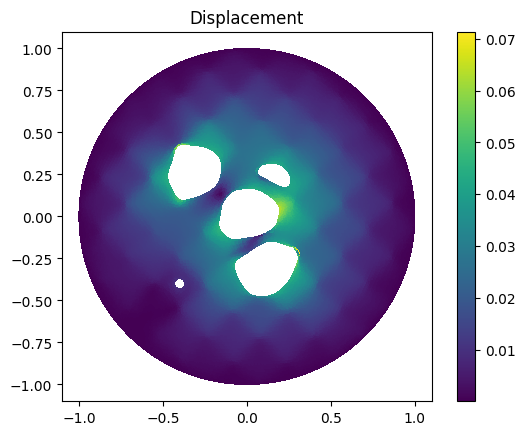

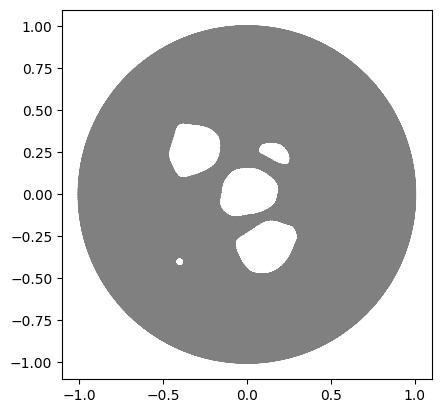

Solving linear variational problem.


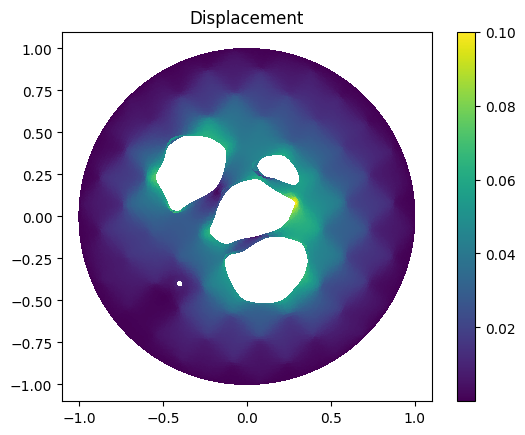

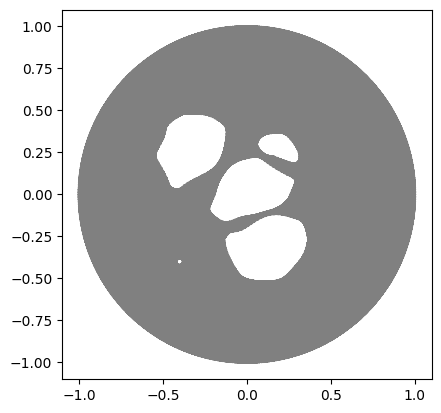

Solving linear variational problem.


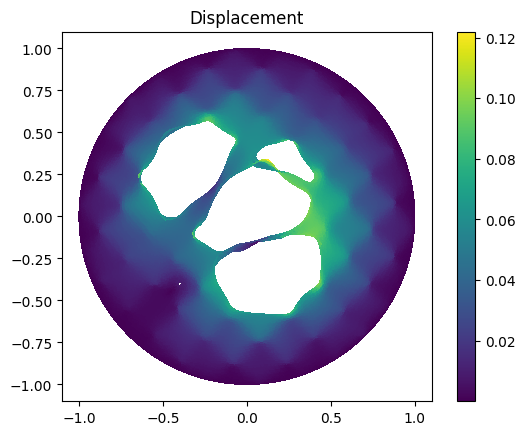

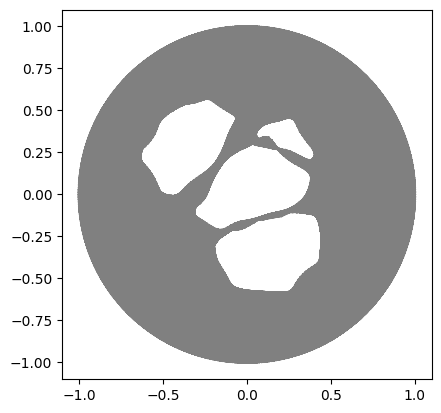

Solving linear variational problem.


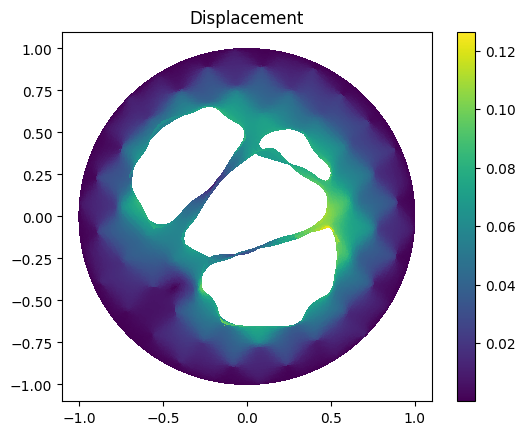

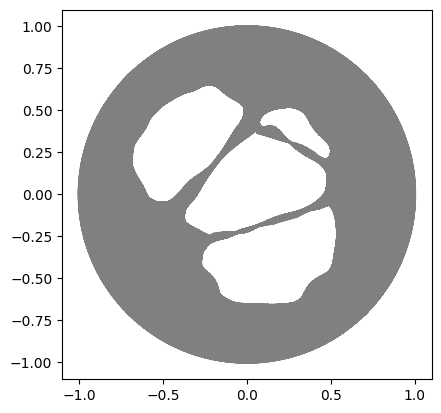

In [82]:

# Create mesh and define function space
filename = "mesh/meshHoles"
mesh_init = Mesh(filename + ".xml")
bounds = MeshFunction("size_t", mesh_init, filename + "_facet_region.xml")
face = MeshFunction("size_t", mesh_init, filename + "_physical_region.xml")
V = VectorFunctionSpace(mesh_init, 'P', 1)

bc_out = DirichletBC(V, Constant((0,0)), bounds, 1)
# bcs = [bc_out]

# # closure of small holes
g = Expression(("-0.01*(x[0]+0.4)/sqrt((x[0]+0.4)*(x[0]+0.4)+(x[1]+0.4)*(x[1]+0.4))", "-0.01*(x[1]+0.4)/sqrt((x[0]+0.4)*(x[0]+0.4)+(x[1]+0.4)*(x[1]+0.4))"), degree=2)
bc_in = DirichletBC(V, g, bounds, 4)
bcs = [bc_out, bc_in]

# Define strain and stress

def epsilon(u):
    return 0.5*(grad(u) + grad(u).T)
    #return sym(nabla_grad(u))

def sigma(u):
    return lambda_*div(u)*Identity(d) + 2*mu*epsilon(u)

def randomMatrix(x):
    # Create an identity matrix
    I = Identity(2)

    # Create a diagonal matrix with sin(x[0])*sin(x[1]) on the diagonal
    D = as_matrix([[0.9*x[0], 0], [0, 0.9*x[1]]])

    # Return the sum of the identity matrix and the diagonal matrix
    return I + D
    
f = Expression(("sin(20*x[0])*sin(20*x[1])", "sin(20*x[0])*sin(20*x[1])"), degree=2)
M = randomMatrix(f)

# Define variational problem
u2 = TrialFunction(V)
v2 = TestFunction(V)
# uh = interpolate(u, V)
f = Constant((0, 0))  # body force
T = Constant((0, 0))
# utest = Expression(("x[0]/5", "x[1]/5"), degree=2)
uh = interpolate(u, V)
a = inner(M*sigma(u2), epsilon(v2))*dx
L = -inner(sigma(uh), epsilon(v2))*dx
u2 = Function(V)


for t in range(5):
# Compute solution
    

    solve(a == L, u2, bcs)

    # Plot solution
    sol = plot(u2, title='Displacement', mode='displacement')
    plt.colorbar(sol)
    plt.show()
    # uh.assign(u2)
    ALE.move(mesh_init, u2)
    
    plot(mesh_init)
    plt.show()

    V = VectorFunctionSpace(mesh_init, 'P', 1)

    bc_out = DirichletBC(V, Constant((0,0)), bounds, 1)
    g = Expression(("-0.01*(x[0]+0.4)/sqrt((x[0]+0.4)*(x[0]+0.4)+(x[1]+0.4)*(x[1]+0.4))", "-0.01*(x[1]+0.4)/sqrt((x[0]+0.4)*(x[0]+0.4)+(x[1]+0.4)*(x[1]+0.4))"), degree=2)
    bc_in = DirichletBC(V, g, bounds, 4)
    bcs = [bc_out, bc_in]
    # bcs = [bc_out]
    f = Expression(("sin(20*x[0])*sin(20*x[1])", "sin(20*x[0])*sin(20*x[1])"), degree=2)
    M = randomMatrix(f)

    u2 = TrialFunction(V)
    v2 = TestFunction(V)
    uh = interpolate(uh, V)
    a = inner(M*sigma(u2), epsilon(v2))*dx
    L = -inner(sigma(uh), epsilon(v2))*dx
    u2 = Function(V)


Solving linear variational problem.


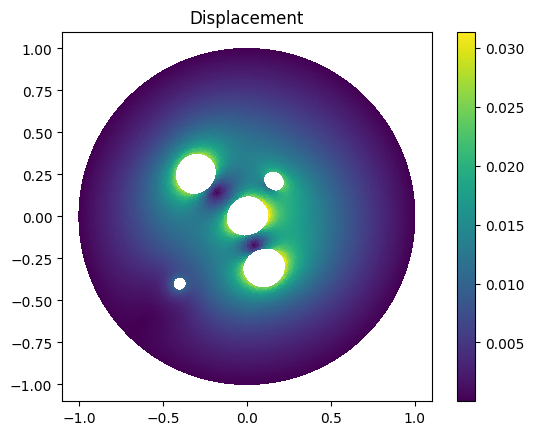

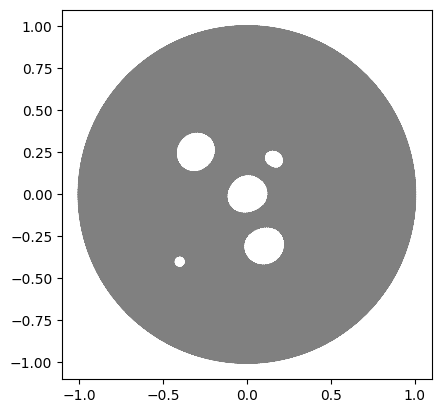

Solving linear variational problem.


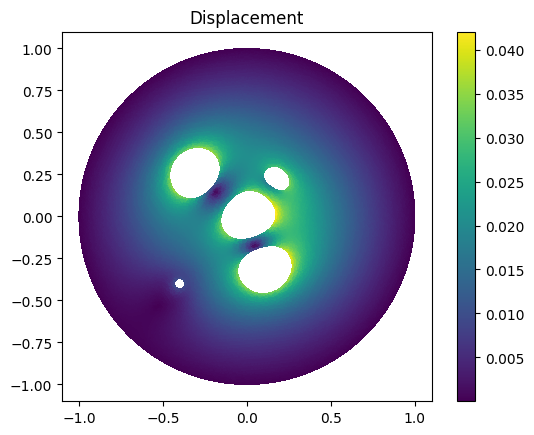

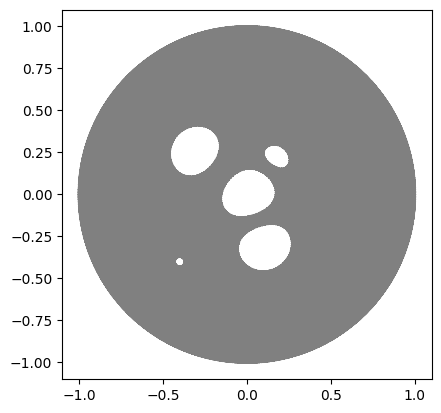

Solving linear variational problem.


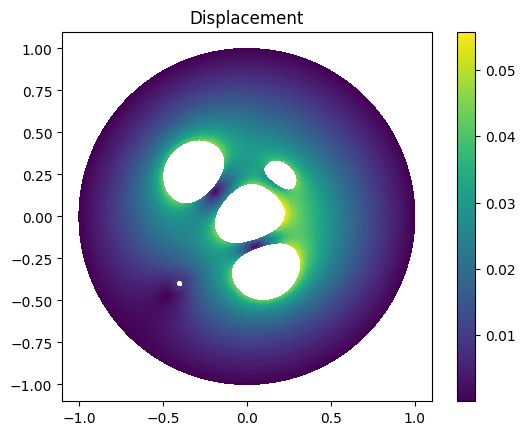

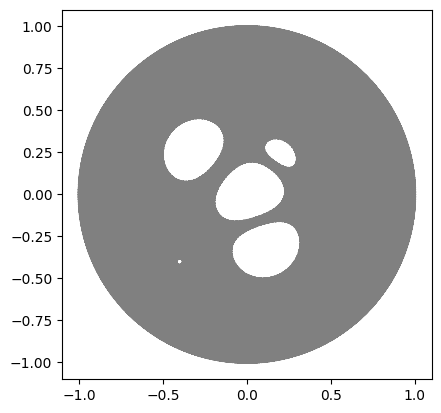

Solving linear variational problem.


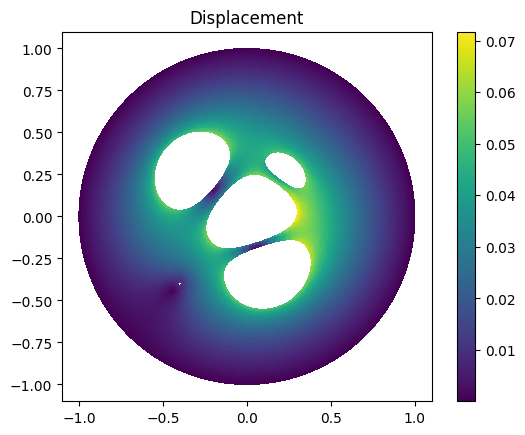

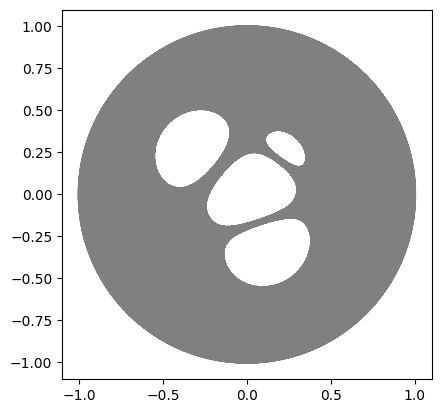

Solving linear variational problem.


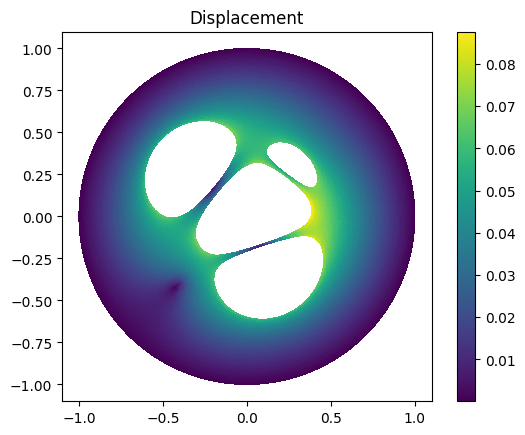

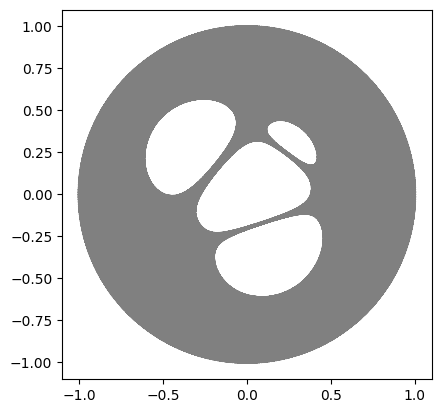

In [83]:

# Create mesh and define function space
filename = "mesh/meshHoles"
mesh_init = Mesh(filename + ".xml")
bounds = MeshFunction("size_t", mesh_init, filename + "_facet_region.xml")
face = MeshFunction("size_t", mesh_init, filename + "_physical_region.xml")
V = VectorFunctionSpace(mesh_init, 'P', 1)

bc_out = DirichletBC(V, Constant((0,0)), bounds, 1)
# bcs = [bc_out]

# # closure of small holes
g = Expression(("-0.01*(x[0]+0.4)/sqrt((x[0]+0.4)*(x[0]+0.4)+(x[1]+0.4)*(x[1]+0.4))", "-0.01*(x[1]+0.4)/sqrt((x[0]+0.4)*(x[0]+0.4)+(x[1]+0.4)*(x[1]+0.4))"), degree=2)
bc_in = DirichletBC(V, g, bounds, 4)
bcs = [bc_out, bc_in]

# Define strain and stress

def epsilon(u):
    return 0.5*(grad(u) + grad(u).T)
    #return sym(nabla_grad(u))

def sigma(u):
    return lambda_*div(u)*Identity(d) + 2*mu*epsilon(u)

def randomMatrix(x):
    # Create an identity matrix
    I = Identity(2)

    # Create a diagonal matrix with sin(x[0])*sin(x[1]) on the diagonal
    D = as_matrix([[x[0], 0], [0, x[1]]])

    # Return the sum of the identity matrix and the diagonal matrix
    return I + D
    
f = Expression(("sin(x[0])*sin(x[1])", "sin(x[0])*sin(x[1])"), degree=2)
M = randomMatrix(f)

# Define variational problem
u2 = TrialFunction(V)
v2 = TestFunction(V)
# uh = interpolate(u, V)
f = Constant((0, 0))  # body force
T = Constant((0, 0))
# utest = Expression(("x[0]/5", "x[1]/5"), degree=2)
uh = interpolate(u, V)
a = inner(sigma(u2), epsilon(v2))*dx
L = -inner(sigma(uh), epsilon(v2))*dx
u2 = Function(V)


for t in range(5):
# Compute solution
    

    solve(a == L, u2, bcs)

    # Plot solution
    sol = plot(u2, title='Displacement', mode='displacement')
    plt.colorbar(sol)
    plt.show()
    # uh.assign(u2)
    ALE.move(mesh_init, u2)
    
    plot(mesh_init)
    plt.show()

    V = VectorFunctionSpace(mesh_init, 'P', 1)

    bc_out = DirichletBC(V, Constant((0,0)), bounds, 1)
    g = Expression(("-0.01*(x[0]+0.4)/sqrt((x[0]+0.4)*(x[0]+0.4)+(x[1]+0.4)*(x[1]+0.4))", "-0.01*(x[1]+0.4)/sqrt((x[0]+0.4)*(x[0]+0.4)+(x[1]+0.4)*(x[1]+0.4))"), degree=2)
    bc_in = DirichletBC(V, g, bounds, 4)
    bcs = [bc_out, bc_in]
    # bcs = [bc_out]
    f = Expression(("sin(x[0])*sin(x[1])", "sin(x[0])*sin(x[1])"), degree=2)
    M = randomMatrix(f)

    u2 = TrialFunction(V)
    v2 = TestFunction(V)
    uh = interpolate(uh, V)
    a = inner(sigma(u2), epsilon(v2))*dx
    L = -inner(sigma(uh), epsilon(v2))*dx
    u2 = Function(V)


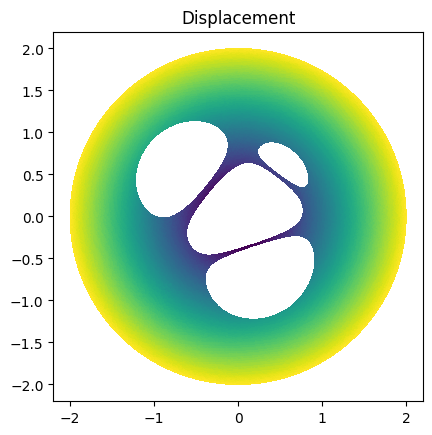

In [84]:
utest = Expression(("x[0]", "x[1]"), degree=2)
utest = interpolate(utest, V)
plot(utest, title='Displacement', mode='displacement')
